In [690]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib import colormaps
import matplotlib.colors as color
import calculators as calc
import conversion as conv
import errors as err
import measures as ms
import tables as tab
import df_transformers as trans
import outlier_cleaners as oucl
from star_calculators import StarCalculator
import regression_models as model
import clustering as cl
import consts as c
import scipy.stats as stat

<h2>Загрузка и первичная очистка данных</h2>

Функция отображения данных по осям логарифма радиуса в Землях и логарифма массы в Землях

In [691]:
def show_mass_radius_plot(p_dfs, s_df, title, reg=None, labels=None):
    fig, axes = plot.subplots()

    if labels:
        labels_app = labels

    else:
        labels_app = ["Внесолнечные объекты" for _ in range(len(p_dfs))]

    for p_df, label in zip(p_dfs, labels_app):
        p_mass = c.mass_log(p_df)
        p_radius = c.radius_log(p_df)
        
        s_mass = c.mass_log(s_df)
        s_radius = c.radius_log(s_df)

        line = axes.scatter(p_mass, p_radius, s=3, alpha=0.4, marker="o")
        line.set_label(label)
        
    
    sl = axes.scatter(s_mass, s_radius, s=15, alpha=0.8, 
                color="#d73737", marker="x"
                )
    
    sl.set_label("Солнечная система")

    axes.legend(loc="lower right")
        
    fig.set_figwidth(9)
    fig.set_figheight(6)

    axes.set_title(title)

    axes.set_xlabel("log(Масса, масс Земли)")
    axes.set_ylabel("log(Радиус, рад. Земли)")

    axes.set_xlim(-2, 5)
    axes.set_ylim(-1, 2)

    if reg:
        min_mass = min(p_mass + s_mass)
        max_mass = max(p_mass + s_mass)

        probe_mass = np.arange(min_mass, max_mass, 0.01)

        s_radius_c = reg.calc(mass=probe_mass)

        axes.plot(probe_mass, s_radius_c, c="#712929")

    plot.show()

def show_mass_radius_hist(df, title):
    def intr_count(df):
        cou = int(np.log2(len(df)))

        return cou

    def vals_by_intr(val, cou):
        min_val = min(val)
        max_val = max(val)

        intr = (max_val - min_val) / cou

        intrs = {}
        for i in np.arange(min_val, max_val, intr):
            intrs[i + intr] = 0

        for m in val:
            for i in reversed(intrs.keys()):
                if m > i:
                    intrs[i] += 1
                    break

        intrs_m = dict(
            map(
                lambda kw: (kw[0] + intr / 2, kw[1]), 
                intrs.items()
            )
        )

        return intrs_m, intr
    
    def get_max_freq(mass_intrs, radius_intrs):
        max_mintr_f = max(mass_intrs.values())
        max_rintr_f = max(radius_intrs.values())

        max_f = max(max_mintr_f, max_rintr_f)

        return max_f

    mass = c.mass_log(df)
    radius = c.radius_log(df)

    intr_c = intr_count(df)

    mass_intrs, mintr = vals_by_intr(mass, intr_c)
    radius_intrs, rintr = vals_by_intr(radius, intr_c)

    fig, axes = plot.subplots(ncols=2)

    fig.set_figwidth(18)
    fig.set_figheight(6)

    fig.suptitle(title)

    axes[0].bar(mass_intrs.keys(), mass_intrs.values(), width=0.9 * mintr, color="#89b949")
    axes[1].bar(radius_intrs.keys(), radius_intrs.values(), width=0.9 * rintr, color="#6969b9")

    max_f = get_max_freq(mass_intrs, radius_intrs)
    for a in axes:
        a.set_ylim(0, max_f * 1.1)

    axes[0].set_title("по массе")
    axes[0].set_xlim(-2, 5)
    axes[0].set_xlabel("log(Масса, масс Земли)")
    
    axes[1].set_title("по радиусу")
    axes[1].set_xlim(-1, 2)
    axes[1].set_xlabel("log(Радиус, рад. Земли)")

Загрузка данных и выбор колонок

In [692]:
cols = [
    "name", 
    "mass", 
    "mass_error_min", 
    "mass_error_max",
    "radius",
    "radius_error_min",
    "radius_error_max",
    "orbital_period",
    "orbital_period_error_min",
    "orbital_period_error_max",
    "semi_major_axis",
    "semi_major_axis_error_min",
    "semi_major_axis_error_max",
    "eccentricity",
    "eccentricity_error_min",
    "eccentricity_error_max",
    "temp_calculated",
    "temp_calculated_error_min",
    "temp_calculated_error_max",
    "temp_measured",
    "star_name",
    "mag_v",
    "star_distance",
    "star_distance_error_min",
    "star_distance_error_max",
    "star_sp_type",
    "star_metallicity",
    "star_metallicity_error_min",
    "star_metallicity_error_max",
    "star_mass",
    "star_mass_error_min",
    "star_mass_error_max",
    "star_radius",
    "star_radius_error_min",
    "star_radius_error_max",
    "star_teff",
    "star_teff_error_min",
    "star_teff_error_max",
]
p_df = pd.read_csv("exo_data.csv")[cols]
s_df = pd.read_csv("sol.csv")[cols]


Выбор объектов, которые являются компаньонами звезд

In [693]:
p_only_comp = p_df.query("star_name.notna() and (orbital_period.notna() or semi_major_axis.notna())")

Выбор объектов, для которых измерены и масса и радиус

In [694]:
p_mass_rad = p_only_comp.query("mass.notna() and radius.notna()")

Гистограммы и распределение выбранных объектов по массе и радиусу

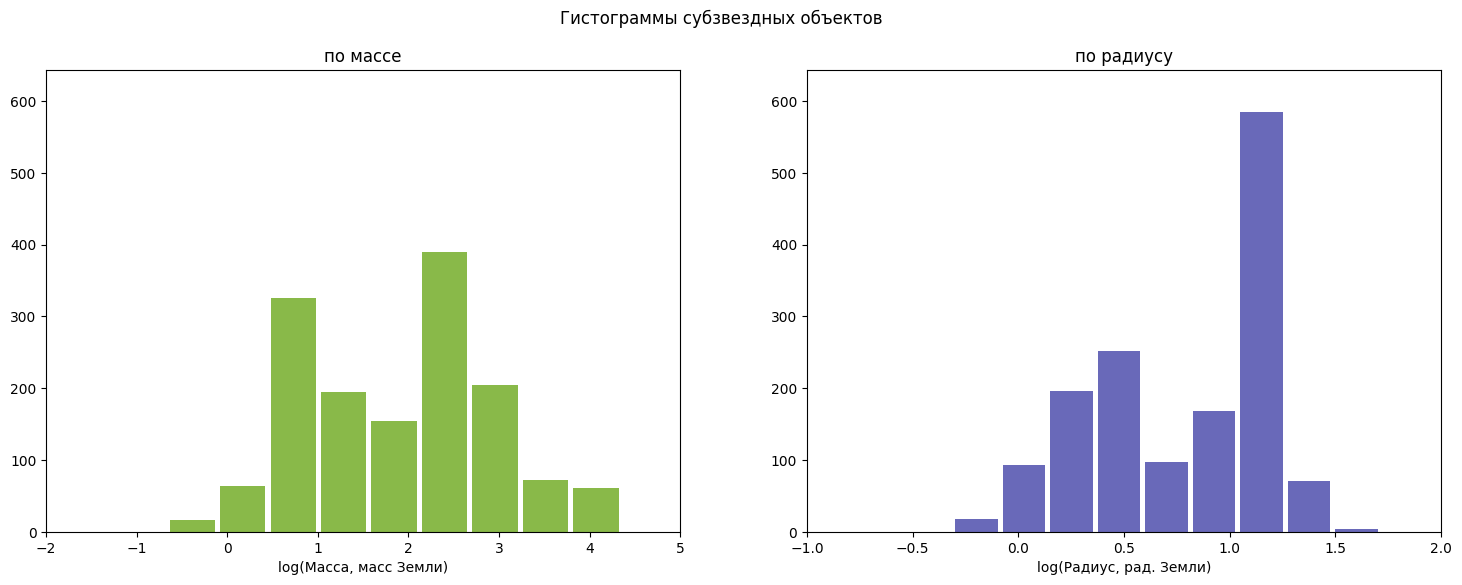

In [695]:
show_mass_radius_hist(p_mass_rad, "Гистограммы субзвездных объектов")

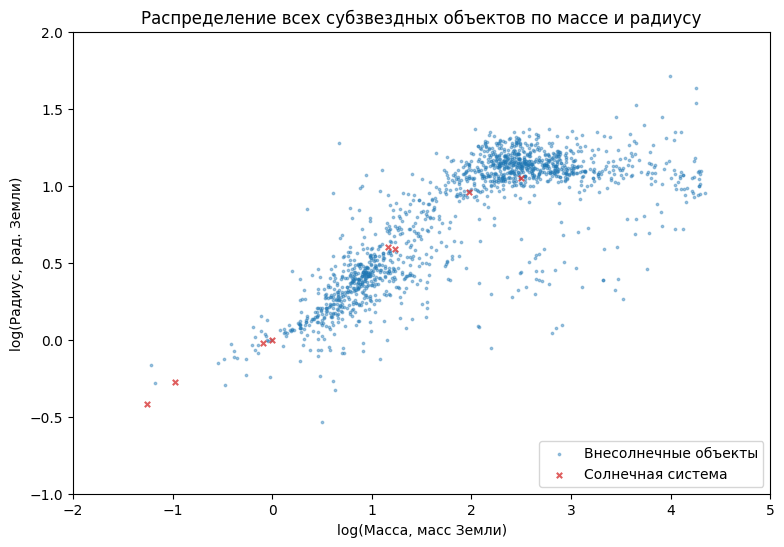

In [696]:
show_mass_radius_plot([p_mass_rad], s_df, "Распределение всех субзвездных объектов по массе и радиусу")

Выбор объектов, с точно измеренными массой и радиусом

Выбираются объекты, относительная погрешность которых не превышает MAX_REL_ERR

In [697]:
MAX_REL_ERR = 0.5

precise_q = "(mass_error_min + mass_error_max) / 2 < mass * {rel_err} and (radius_error_min + radius_error_max) / 2 < radius * {rel_err}".format(rel_err=MAX_REL_ERR)
p_precise = p_mass_rad.query(precise_q)

Гистограммы и распределение выбранных объектов по массе и радиусу

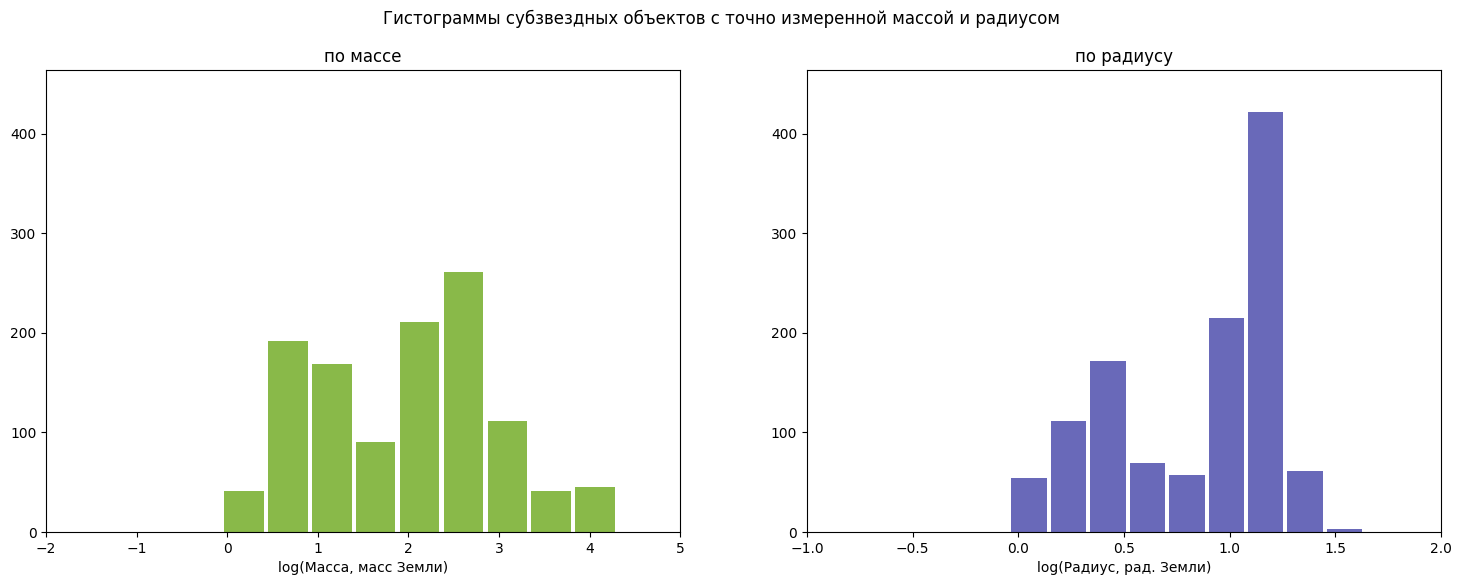

In [698]:
show_mass_radius_hist(p_precise, "Гистограммы субзвездных объектов с точно измеренной массой и радиусом")

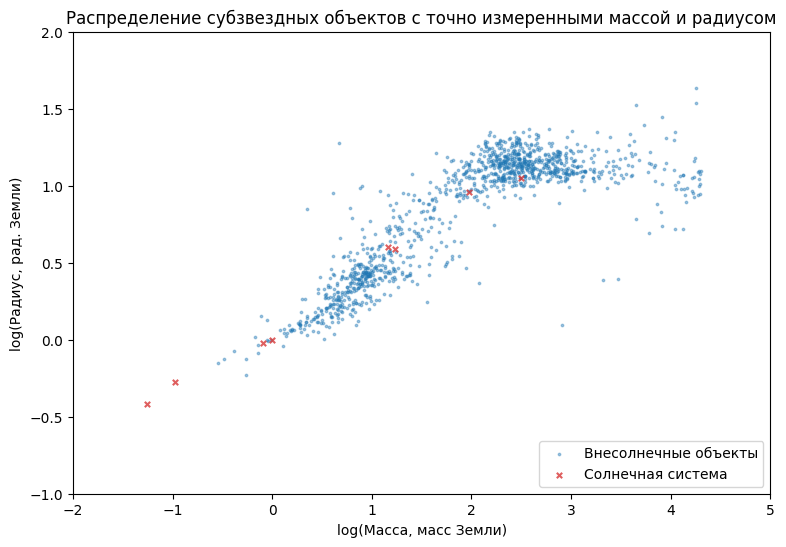

In [699]:
show_mass_radius_plot([p_precise], s_df, "Распределение субзвездных объектов с точно измеренными массой и радиусом")

Выбор объектов планетарной массы

Объектами планетарной массы будем считать те объекты, масса которых не превышает MAX_PL_MASS_JUP масс ЮПИТЕРА

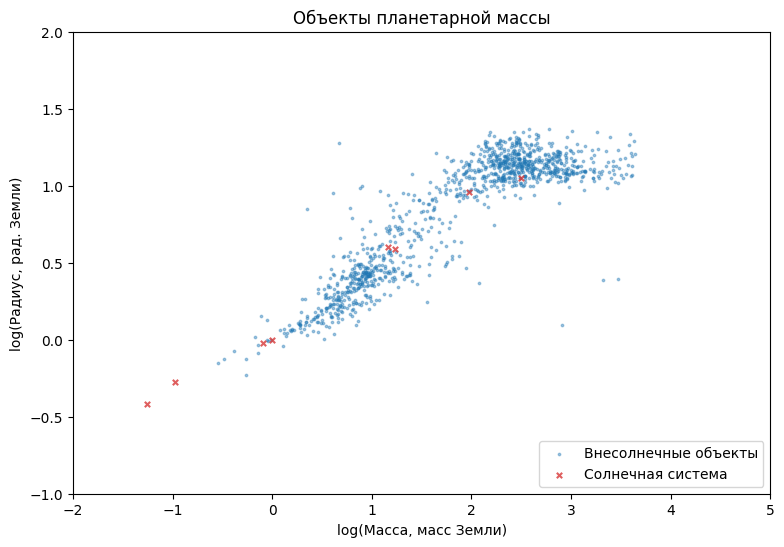

In [700]:
MAX_PL_MASS_JUP = 14

only_planets_q = "mass < {mass}".format(mass=MAX_PL_MASS_JUP)
p_only_planets = p_precise.query(only_planets_q)

show_mass_radius_plot([p_only_planets], s_df, "Объекты планетарной массы")

Очистка данных от выбросов по радиусу

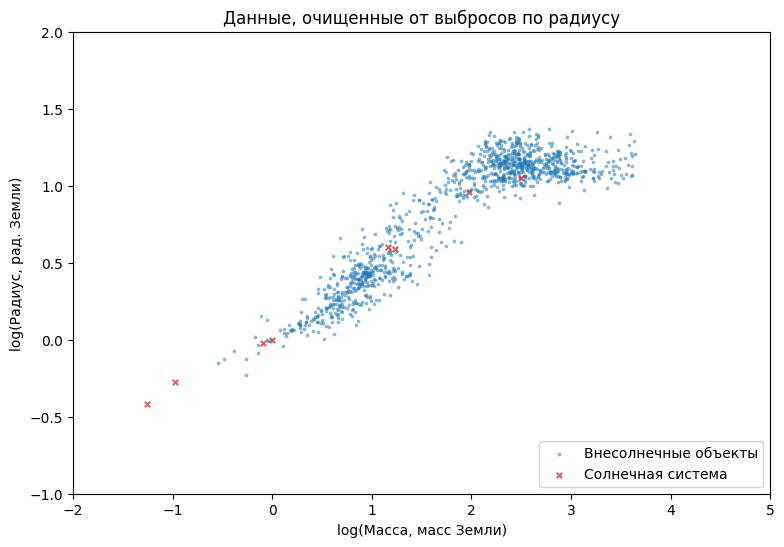

In [701]:
mr_ouclean = oucl.MassRadiusOutlierCleaner(5, 10, tree_count=100, seed=122)

p_only_planets_cl = mr_ouclean.clean(p_only_planets, 0.1)

show_mass_radius_plot([p_only_planets_cl], s_df, "Данные, очищенные от выбросов по радиусу")

<h2>Обучение модели массы-радиуса</h2>

Обучение регрессии, определяющий радиус планеты по её массе

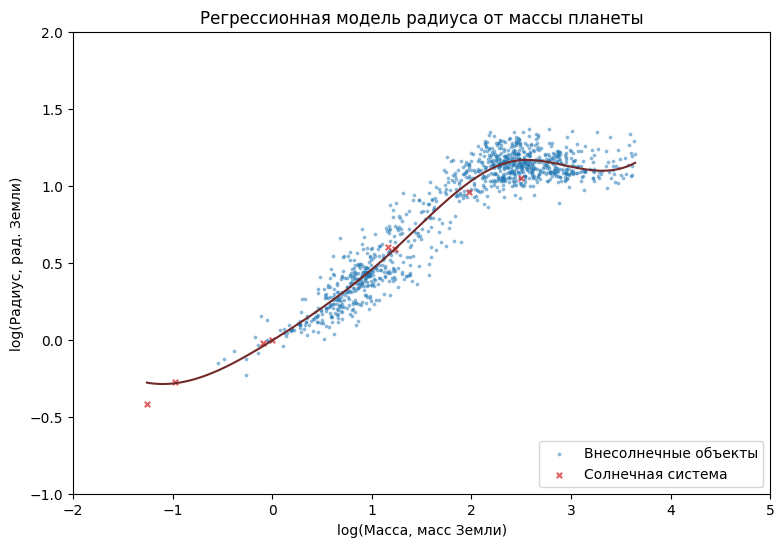

R2 регрессии: 0.93


In [702]:
p_concat = pd.concat([p_only_planets_cl, s_df], ignore_index=True)

mr_model = model.MassRadiusLogRegression()
mr_model.learn(p_concat)

show_mass_radius_plot([p_only_planets_cl], s_df, "Регрессионная модель радиуса от массы планеты", reg=mr_model)
print("R2 регрессии: {0:.2f}".format(mr_model.R2))

Сохранение предварительно отфильтрованные данные в файл

In [703]:
p_only_planets_cl.to_csv("exo_filtered.csv")

<h2>Кластеризация планет по массе и радиусу</h2>

Разделение планет по массе и радиусу на два кластера

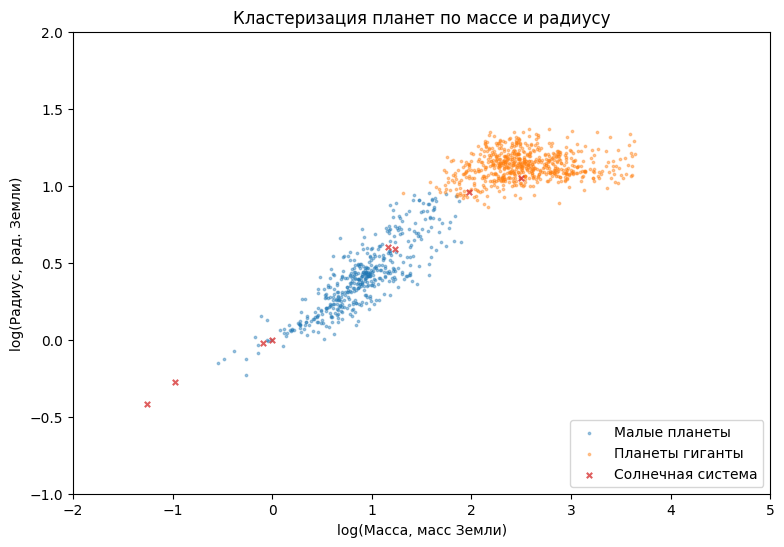

In [704]:
mr_clst = cl.MassRadiusClusterer(2)

cl_dfs = mr_clst.learn(p_only_planets_cl)
cl_dfs = sorted(cl_dfs, key=lambda df: df["mass"].mean())

show_mass_radius_plot(cl_dfs, s_df, "Кластеризация планет по массе и радиусу", labels=["Малые планеты", "Планеты гиганты"])

Таким образом мы разделили выборку планет на две группы:
<ol>
<li>Планеты гиганты - наиболее крупные и массивные планеты, радиус которых мало изменяется с ростом массы</li>
<li>Малые планеты - более легкие и малые планеты, радиус которых возрастает с ростом массы.</li>
</ol>

<h2>Расчет недостающих данных</h2>

In [705]:
SP_CLASS_TABLE = {
    "B": (10000.0, 30000.0),
    "A": (7400.0, 10000.0),
    "F": (6000.0, 7400.0),
    "G": (5000.0, 6000.0),
    "K": (3800.0, 5000.0),
    "M": (2500.0, 3800.0),
    "L": (1300.0, 2500.0),
    "T": (600.0, 1300.0)
}

In [706]:
converter = conv.MeasureConverter()
rou = err.Round()

Генерация погрешности для данных, где они не указаны

In [707]:
err_gen_by_order = err.ErrorGeneratorByOrder()
err_gen_star_teff = err.ErrorGeneratorStarTeff()

period_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "orbital_period", ms.OrbitalPeriod)
smass_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "star_mass", ms.SemiMajorAxis)
steff_err_gen = trans.DFErrorGen(converter, err_gen_star_teff, "star_teff", ms.StarTeff)
smaxis_err_gen = trans.DFErrorGen(converter, err_gen_by_order, "semi_major_axis", ms.SemiMajorAxis)

calc_cl_dfs = []

for cl_df in cl_dfs:
    calc_df = period_err_gen.gen(cl_df)
    calc_df = smass_err_gen.gen(calc_df)
    calc_df = steff_err_gen.gen(calc_df)
    calc_df = smaxis_err_gen.gen(calc_df)
    calc_cl_dfs.append(calc_df)

Определение эффективной температуры фотосферы звезды по спектральному классу

In [708]:
steff_table = tab.SpClassTeffTable(SP_CLASS_TABLE)

steff_calc_df = trans.DFStarTeffBySpClassCalc(converter, steff_table)

calc_cl_dfs = list(map(lambda df: steff_calc_df.set_vals(df), calc_cl_dfs))

{'B-1': TableValue(val=20000.0, err=20000.0), 'B0.0': TableValue(val=29000.0, err=1000.0), 'B0.5': TableValue(val=28000.0, err=1000.0), 'B1.0': TableValue(val=27000.0, err=1000.0), 'B1.5': TableValue(val=26000.0, err=1000.0), 'B2.0': TableValue(val=25000.0, err=1000.0), 'B2.5': TableValue(val=24000.0, err=1000.0), 'B3.0': TableValue(val=23000.0, err=1000.0), 'B3.5': TableValue(val=22000.0, err=1000.0), 'B4.0': TableValue(val=21000.0, err=1000.0), 'B4.5': TableValue(val=20000.0, err=1000.0), 'B5.0': TableValue(val=19000.0, err=1000.0), 'B5.5': TableValue(val=18000.0, err=1000.0), 'B6.0': TableValue(val=17000.0, err=1000.0), 'B6.5': TableValue(val=16000.0, err=1000.0), 'B7.0': TableValue(val=15000.0, err=1000.0), 'B7.5': TableValue(val=14000.0, err=1000.0), 'B8.0': TableValue(val=13000.0, err=1000.0), 'B8.5': TableValue(val=12000.0, err=1000.0), 'B9.0': TableValue(val=11000.0, err=1000.0), 'B9.5': TableValue(val=10000.0, err=1000.0), 'A-1': TableValue(val=8700.0, err=2600.0), 'A0.0': Tab

Расчет большой полуоси орбиты планеты

In [709]:
smaxis_calc = calc.SemiMajorAxisCalc()

sm_axis_calc_df = trans.DFSemiMajorAxisCalc(converter, smaxis_calc, rou)

calc_cl_dfs = list(map(lambda df: sm_axis_calc_df.calc(df), calc_cl_dfs))

Расчет средней эффективной температуры планеты

In [710]:
pteff_mean_calc = calc.PlanetTeffCalc()

pteff_mean_calc_df = trans.DFPlanetTeffMeanCalc(converter, pteff_mean_calc, rou)

calc_cl_dfs = list(map(lambda df: pteff_mean_calc_df.calc(df), calc_cl_dfs))

calc_dfs_merge = pd.concat(calc_cl_dfs, ignore_index=True)
calc_df.to_csv("exo_with_teff.csv")

Распределение планет с разными массами и радиусами по эффективной температуре

In [711]:
BG_COLOR = "0.15"
PLOT_BG_COLOR = "0.18"
T_TITLE_COLOR = "white"
T_COLOR = "0.8"

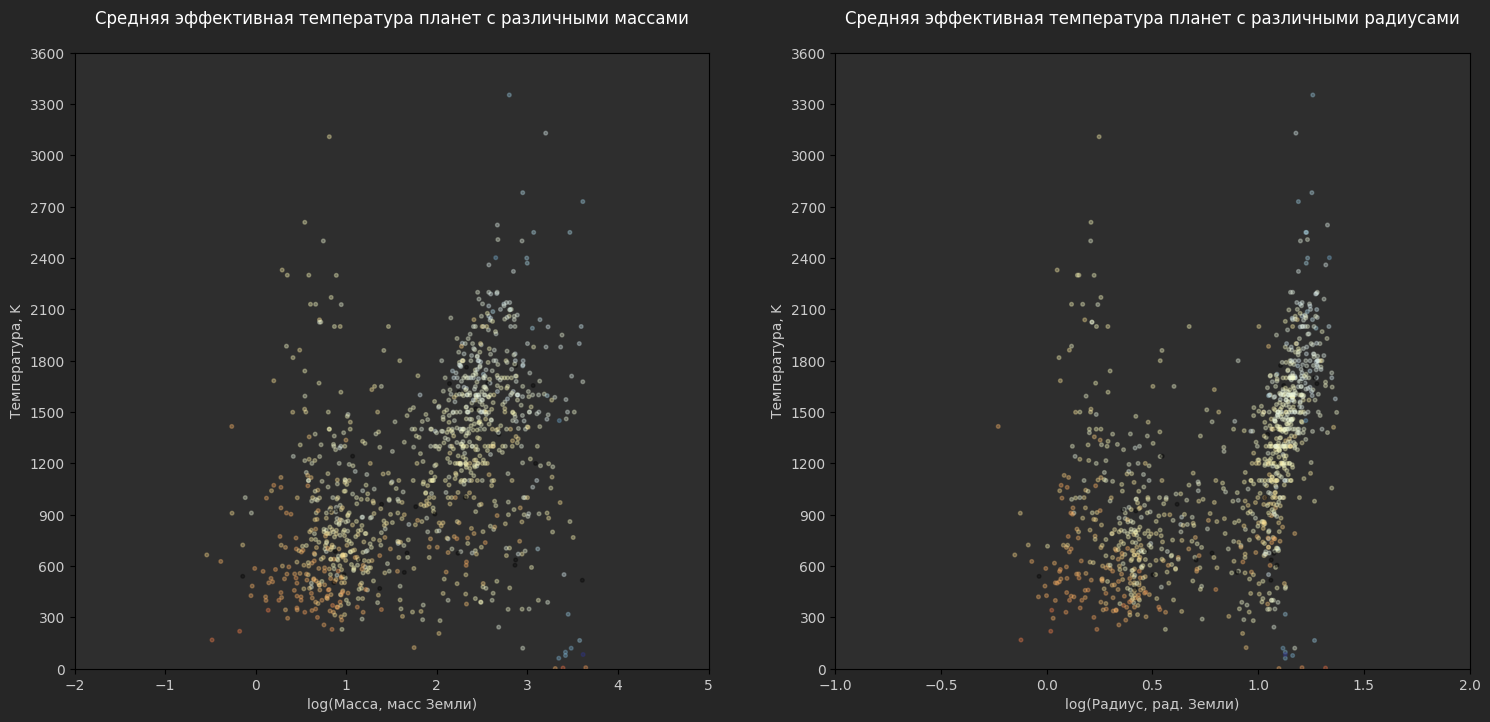

In [712]:
mean_teff = calc_dfs_merge.get("temp_calculated").tolist()
star_teff = calc_dfs_merge.get("star_teff").tolist()
val = c.mass_log(calc_dfs_merge)
radius = c.radius_log(calc_dfs_merge)

fig, axes = plot.subplots(facecolor=BG_COLOR, ncols=2)

fig.set_figwidth(18)
fig.set_figheight(8)

colormap = colormaps.get_cmap("RdYlBu")
norm = color.Normalize(0, 11000)

axes[0].scatter(val, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))
axes[1].scatter(radius, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))

for a in axes:
    a.set_facecolor(PLOT_BG_COLOR)

    a.set_ylabel("Температура, K", color=T_COLOR)
    a.set_ylim(0, 3000)
    a.set_yticks(np.arange(0, 3800, 300))

    a.tick_params(labelcolor=T_COLOR)

axes[0].set_title("Cредняя эффективная температура планет с различными массами\n", color=T_TITLE_COLOR)
axes[0].set_xlabel("log(Масса, масс Земли)", color=T_COLOR)
axes[0].set_xlim(-2, 5)

axes[1].set_title("Cредняя эффективная температура планет с различными радиусами\n", color=T_TITLE_COLOR)
axes[1].set_xlabel("log(Радиус, рад. Земли)", color=T_COLOR)
axes[1].set_xlim(-1, 2)

plot.show()

Расчет массы родительской звезды по большим полуосям и орбитальным периодам ее планет

In [713]:
smass_calc = calc.StarMassCalc()

smass_calc_df = trans.DFStarMassCalculator(converter, smass_calc, rou, StarCalculator)

smass_cl_dfs = list(map(lambda df: smass_calc_df.calc(df), calc_cl_dfs))

smass_df = pd.concat(smass_cl_dfs, ignore_index=True)
smass_df.to_csv("exo_with_star_mass.csv")

Функция отображения распределения масс планет по массам родительских звезд и их металличности

In [714]:
def show_star_mass_feh_plots(dfs, title=None, labels=None):
    fig, axes = plot.subplots(ncols=2)

    fig.set_figwidth(18)
    fig.set_figheight(6)

    if title:
        fig.suptitle("{0}\n".format(title))

    if labels:
        ls = labels

    else:
        ls = ["Планеты" for _ in range(len(dfs))]

    for df, l in zip(dfs, ls):
        s_mass = df.get("star_mass").tolist()
        s_feh = df.get("star_metallicity").tolist()
        val = c.mass_log(df)

        sca_sm = axes[0].scatter(s_mass, val, s=7, alpha=0.33)
        sca_feh = axes[1].scatter(s_feh, val, s=7, alpha=0.33)
        
        sca_sm.set_label(l)
        sca_feh.set_label(l)

    for a in axes:
        a.set_ylabel("log(Масса планеты, масс Земли)")
        a.set_ylim(-2, 5)
        a.legend(loc="lower right")

    axes[0].set_title("Распределение масс планет по массам родительских звезд\n")
    axes[0].set_xlabel("Масса звезды, масс Солнца")

    axes[1].set_title("Распределение масс планет по металличности родительских звезд\n")
    axes[1].set_xlabel("Металличность звезды Fe/H")

    plot.show()

Распределение планет с различными массами по массам родительских звезд и их металличности

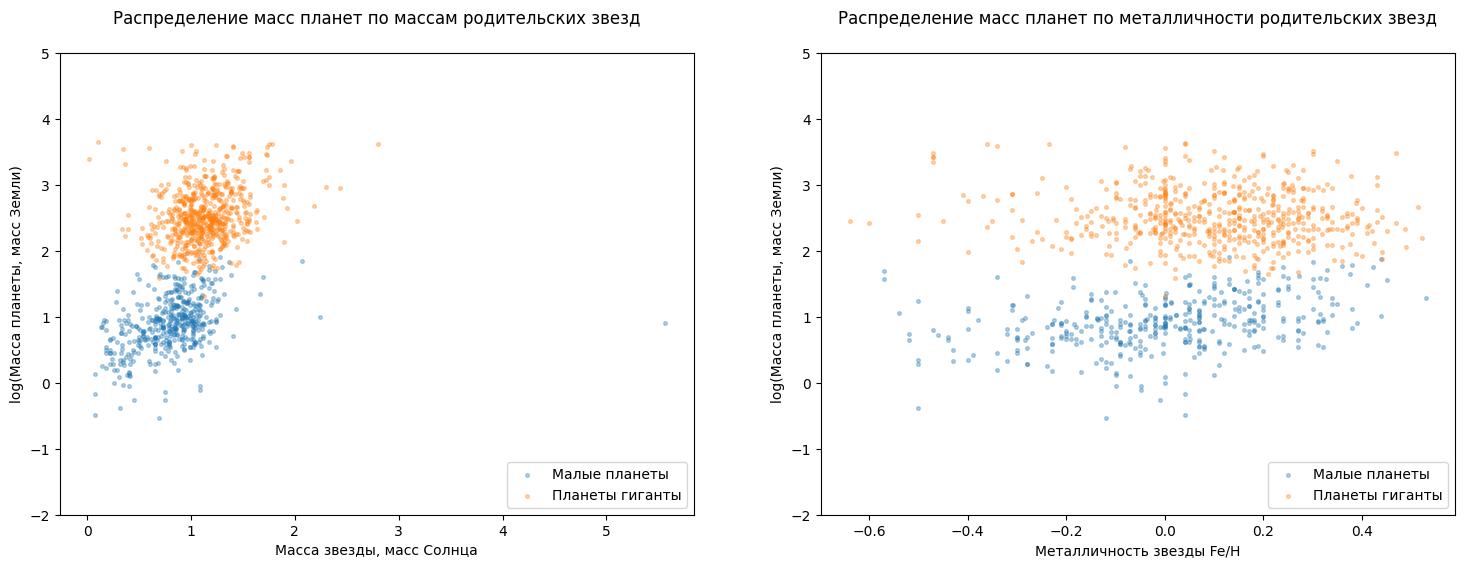

In [715]:
show_star_mass_feh_plots(smass_cl_dfs, labels=["Малые планеты", "Планеты гиганты"])

Удаление планет, с неточно определенной массой родительской звезды

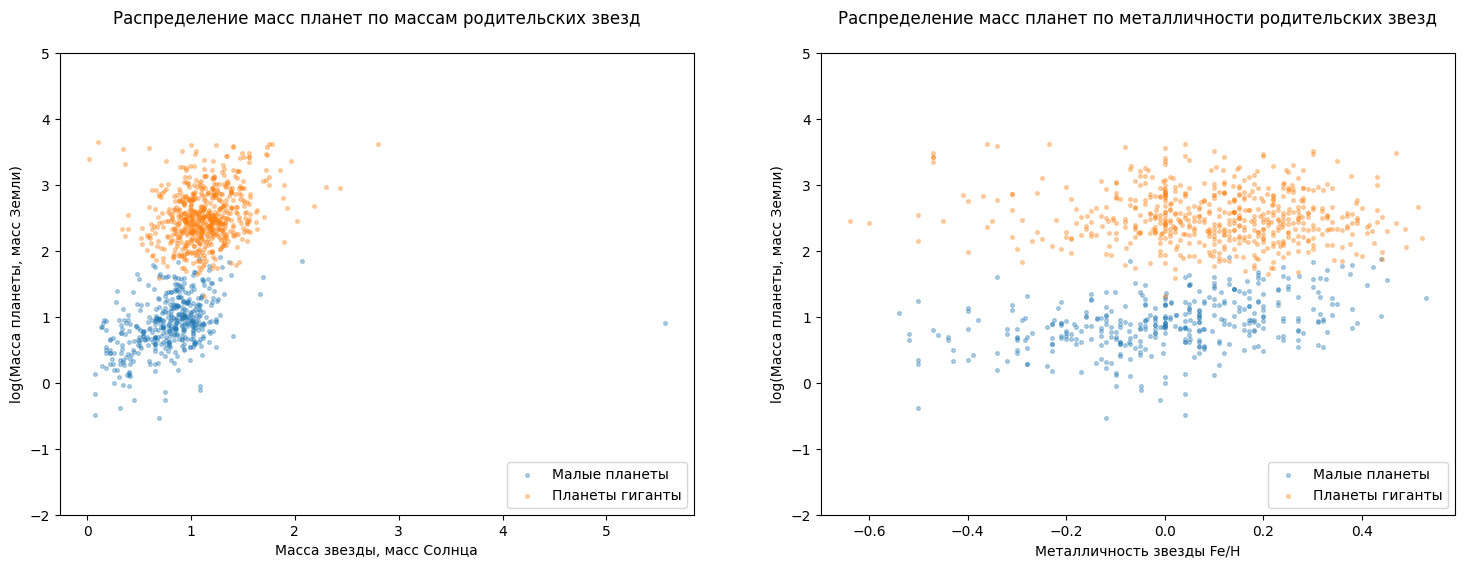

In [716]:
SM_RERR = 0.5
f_by_sm_query = "(star_mass_error_min + star_mass_error_max) / 2 <= {0} * star_mass".format(SM_RERR)

dfs_f_by_sm = list(map(
    lambda df: df.query(f_by_sm_query),
    smass_cl_dfs
))

show_star_mass_feh_plots(dfs_f_by_sm, labels=["Малые планеты", "Планеты гиганты"])

Очистка выбросов на плоскости массы родительской звезды и массы планеты

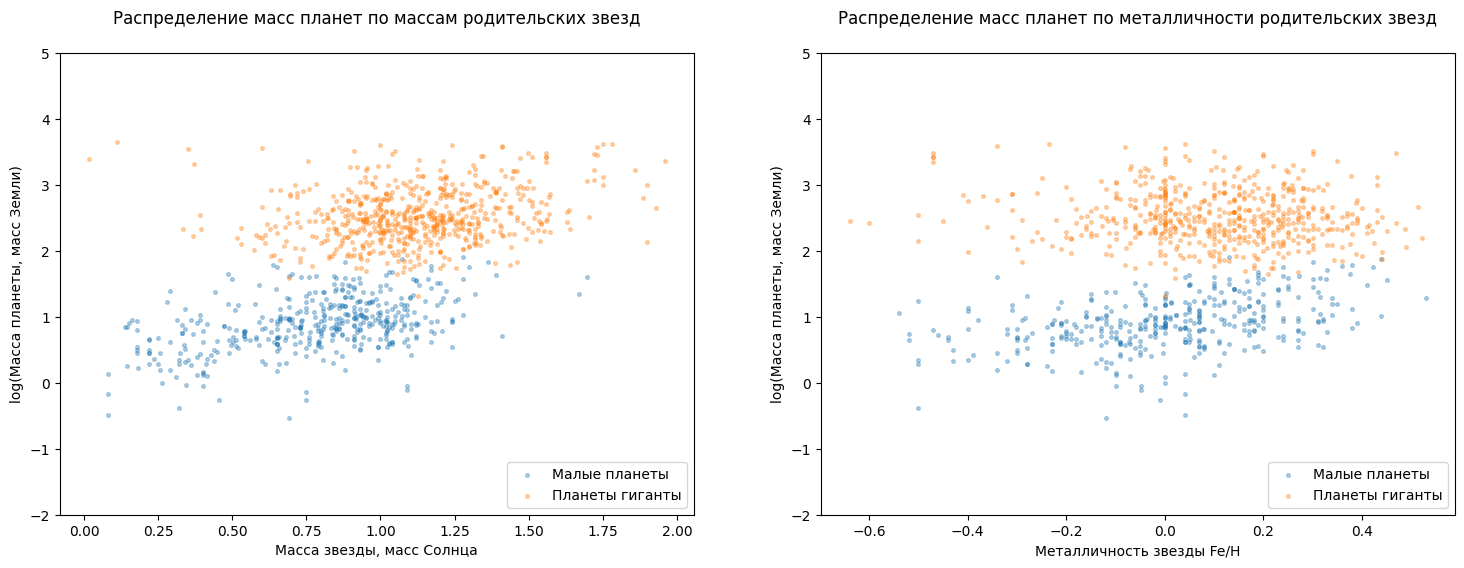

In [717]:
sp_mass_clean = oucl.SPMassOutlierCleaner()

dfs_ms_cleaned = list(map(lambda df: sp_mass_clean.clean(df), dfs_f_by_sm))

show_star_mass_feh_plots(dfs_ms_cleaned, labels=["Малые планеты", "Планеты гиганты"])

In [718]:
sm_small_p = dfs_ms_cleaned[0]["star_mass"]
sm_large_p = dfs_ms_cleaned[1]["star_mass"]

sm_small_p_mean = sm_small_p.mean()
sm_large_p_mean = sm_large_p.mean()
sm_total_mean = (sm_small_p_mean + sm_large_p_mean) / 2

sm_small_p_std = sm_small_p.std()
sm_large_p_std = sm_large_p.std()

sm_ttest_cross = stat.ttest_ind(sm_small_p, sm_large_p)
sm_ttest_small = stat.ttest_1samp(sm_small_p, sm_total_mean)
sm_ttest_large = stat.ttest_1samp(sm_large_p, sm_total_mean)

sm_sigma_cross = abs(sm_ttest_cross.statistic)
sm_sigma_small = abs(sm_ttest_small.statistic)
sm_sigma_large = abs(sm_ttest_large.statistic)

print("Cредние:")
print(
    "Среднее значение массы родительской звезды для малых планет: {0:.2f}"
        .format(sm_small_p_mean)
)
print(
    "Среднее значение массы родительской звезды для планет гигантов: {0:.2f}"
        .format(sm_large_p_mean)
)
print(
    "Общее среднее масс родительских звезд: {0:.2f}"
        .format(sm_total_mean)
)

print()
print("Стандартные отклонения:")
print(
    "Стандартное отклонение родительской звезды для малых планет: {0:.2f}"
        .format(sm_small_p_std)
)
print(
    "Стандартное отклонение массы родительской звезды для планет гигантов: {0:.2f}"
        .format(sm_large_p_std)
)

print()
print("T-тесты средних:")
print(
    "Достоверность различия среднего малых планет от общего среднего {0:.2f} сигма"
        .format(sm_sigma_small)
)
print(
    "Достоверность различия среднего планет гигантов от общего среднего {0:.2f} сигма"
        .format(sm_sigma_large)
)
print(
    "Достоверность различия средних между группами {0:.2f} сигма"
        .format(sm_sigma_cross)
)

Cредние:
Среднее значение массы родительской звезды для малых планет: 0.79
Среднее значение массы родительской звезды для планет гигантов: 1.12
Общее среднее масс родительских звезд: 0.95

Стандартные отклонения:
Стандартное отклонение родительской звезды для малых планет: 0.29
Стандартное отклонение массы родительской звезды для планет гигантов: 0.27

T-тесты средних:
Достоверность различия среднего малых планет от общего среднего 12.10 сигма
Достоверность различия среднего планет гигантов от общего среднего 15.63 сигма
Достоверность различия средних между группами 19.39 сигма


In [719]:
feh_small_p = dfs_ms_cleaned[0]["star_metallicity"].dropna()
feh_large_p = dfs_ms_cleaned[1]["star_metallicity"].dropna()

feh_small_p_mean = feh_small_p.mean()
feh_large_p_mean = feh_large_p.mean()
feh_total_mean = (feh_small_p_mean + feh_large_p_mean) / 2

feh_small_p_std = feh_small_p.std()
feh_large_p_std = feh_large_p.std()

feh_ttest_cross = stat.ttest_ind(feh_small_p, feh_large_p)
feh_ttest_small = stat.ttest_1samp(feh_small_p, feh_total_mean)
feh_ttest_large = stat.ttest_1samp(feh_large_p, feh_total_mean)

feh_sigma_cross = abs(feh_ttest_cross.statistic)
feh_sigma_small = abs(feh_ttest_small.statistic)
feh_sigma_large = abs(feh_ttest_small.statistic)

print("Средние:")
print(
    "Среднее значение металличности родительской звезды для малых планет: {0:.2f}"
        .format(feh_small_p_mean)
)
print(
    "Среднее значение металличности родительской звезды для планет гигантов: {0:.2f}"
        .format(feh_large_p_mean)
)
print(
    "Общее среднее металличности: {0:.2f}"
        .format(feh_total_mean)
)

print()
print("Стандартные отклонения:")
print(
    "Стандартное отклонение металличности родительской звезды для малых планет: {0:.2f}"
        .format(feh_small_p_std)
)
print(
    "Стандартное отклонение металличности родительской звезды для планет гигантов: {0:.2f}"
        .format(feh_large_p_std)
)

print()
print("T-тесты средних:")
print(
    "Достоверность различия среднего малых планет от общего среднего {0:.2f} сигма"
        .format(feh_sigma_small)
)
print(
    "Достоверность различия среднего планет гигантов от общего среднего {0:.2f} сигма"
        .format(feh_sigma_large)
)
print(
    "Достоверность различия средних между группами {0:.2f} сигма"
        .format(feh_sigma_cross)
)

Средние:
Среднее значение металличности родительской звезды для малых планет: 0.00
Среднее значение металличности родительской звезды для планет гигантов: 0.10
Общее среднее металличности: 0.05

Стандартные отклонения:
Стандартное отклонение металличности родительской звезды для малых планет: 0.20
Стандартное отклонение металличности родительской звезды для планет гигантов: 0.19

T-тесты средних:
Достоверность различия среднего малых планет от общего среднего 4.50 сигма
Достоверность различия среднего планет гигантов от общего среднего 4.50 сигма
Достоверность различия средних между группами 7.30 сигма
